<a target="_blank" href="https://colab.research.google.com/github/Jasonchen0317/CSGY-6613-Assignment/blob/main/assignment-2/assignment_2_rareEvents.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
# import os
# os.environ['LD_LIBRARY_PATH'] = '/workspaces/artificial_intelligence/.venv/lib/python3.11/site-packages/tensorrt_libs'

import tensorflow as tf
import pandas as pd
import keras
import optuna
from keras import layers
from keras import models 
from sklearn.model_selection import train_test_split
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

c:\Users\jason\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os, shutil

In [4]:
train_path = "C:/kaggle/dogs-vs-cats/train.zip"
test_path = "C:/kaggle/dogs-vs-cats/test1.zip"

files = "C:/kaggle/working/"

import zipfile

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)
    
with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

KeyboardInterrupt: 

In [17]:
image_dir = "C:/kaggle/working/train/"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [18]:
data = data.sample(frac =0.16) 

In [19]:
labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.5, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (2000, 2)
The shape of test data (1000, 2)
The shape of validation data (1000, 2)


In [20]:
image_size = 150
image_channel = 3
bat_size = 20

In [21]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = image_dir,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
validation_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = image_dir,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = image_dir,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 2000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [101]:
def create_cnn_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    
    num_hidden = trial.suggest_categorical("num_hidden", [128, 256, 512])
    
    model = models.Sequential()
    model.add(layers.Conv2D(
                filters=trial.suggest_categorical("filters1", [32, 64]),
                kernel_size=trial.suggest_categorical("kernel_size1", [3, 5]),
                activation='relu',
                input_shape=(150, 150, 3)
                )
            )
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
                filters=trial.suggest_categorical("filters2", [32, 64]),
                kernel_size=trial.suggest_categorical("kernel_size2", [3, 5]),
                activation='relu'
                )
            )
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
                filters=trial.suggest_categorical("filters3", [64, 128]),
                kernel_size=trial.suggest_categorical("kernel_size3", [3, 5]),
                activation='relu'
                )
            )
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
                filters=trial.suggest_categorical("filters4", [64, 128]),
                kernel_size=trial.suggest_categorical("kernel_size4", [3, 5]),
                activation='relu'
                )
            )
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_hidden, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(2, activation='sigmoid'))
    
    
    
    
    return model

In [102]:
def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["weight_decay"] = trial.suggest_float("rmsprop_weight_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

In [103]:
def objective_cnn(trial):
    # Get MNIST data.

    # Build model and optimizer.
    model = create_cnn_model(trial)
    
    optimizer = create_optimizer(trial)
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )
    model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      batch_size=128
    )
    score = model.evaluate(test_generator, verbose=0)
    return score[1]

In [104]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_cnn, n_trials=100, timeout=6000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-05 20:58:17,822] A new study created in memory with name: no-name-d8e76212-7b04-4f61-b204-d5a5bde5e8bf


Epoch 1/10
100/100 [==============================] - 19s 175ms/step - loss: 0.6942 - accuracy: 0.5195 - val_loss: 0.6908 - val_accuracy: 0.5470
Epoch 2/10
100/100 [==============================] - 17s 175ms/step - loss: 0.6890 - accuracy: 0.5345 - val_loss: 0.6889 - val_accuracy: 0.5740
Epoch 3/10
100/100 [==============================] - 17s 171ms/step - loss: 0.6840 - accuracy: 0.5705 - val_loss: 0.6860 - val_accuracy: 0.5450
Epoch 4/10
100/100 [==============================] - 17s 173ms/step - loss: 0.6791 - accuracy: 0.5810 - val_loss: 0.6828 - val_accuracy: 0.6140
Epoch 5/10
100/100 [==============================] - 27s 273ms/step - loss: 0.6716 - accuracy: 0.6030 - val_loss: 0.6823 - val_accuracy: 0.5210
Epoch 6/10
100/100 [==============================] - 37s 364ms/step - loss: 0.6623 - accuracy: 0.6125 - val_loss: 0.6719 - val_accuracy: 0.6080
Epoch 7/10
100/100 [==============================] - 17s 170ms/step - loss: 0.6505 - accuracy: 0.6395 - val_loss: 0.6662 - val_ac

[I 2023-10-05 21:01:42,781] Trial 0 finished with value: 0.6549999713897705 and parameters: {'n_cov_layers': 4, 'n_layers': 3, 'weight_decay': 7.418119526344144e-10, 'num_hidden': 512, 'filters1': 32, 'kernel_size1': 3, 'filters2': 32, 'kernel_size2': 3, 'filters3': 64, 'kernel_size3': 3, 'filters4': 128, 'kernel_size4': 3, 'optimizer': 'Adam', 'adam_learning_rate': 1.7063662242594414e-05}. Best is trial 0 with value: 0.6549999713897705.


Epoch 1/10
100/100 [==============================] - 62s 593ms/step - loss: 2.2378 - accuracy: 0.4890 - val_loss: 0.6933 - val_accuracy: 0.4980
Epoch 2/10
100/100 [==============================] - 57s 572ms/step - loss: 0.6934 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 3/10
100/100 [==============================] - 57s 570ms/step - loss: 0.6935 - accuracy: 0.4835 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 4/10
100/100 [==============================] - 57s 566ms/step - loss: 0.6934 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 5/10
100/100 [==============================] - 57s 571ms/step - loss: 0.6934 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 6/10
100/100 [==============================] - 56s 559ms/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 7/10
100/100 [==============================] - 56s 559ms/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6931 - val_ac

[I 2023-10-05 21:12:21,975] Trial 1 finished with value: 0.5019999742507935 and parameters: {'n_cov_layers': 4, 'n_layers': 3, 'weight_decay': 3.3360451799775936e-09, 'num_hidden': 512, 'filters1': 64, 'kernel_size1': 5, 'filters2': 64, 'kernel_size2': 5, 'filters3': 128, 'kernel_size3': 5, 'filters4': 128, 'kernel_size4': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.006348331710411272}. Best is trial 0 with value: 0.6549999713897705.


Epoch 1/10
100/100 [==============================] - 21s 194ms/step - loss: 0.9126 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 2/10
100/100 [==============================] - 19s 194ms/step - loss: 0.6937 - accuracy: 0.4890 - val_loss: 0.6929 - val_accuracy: 0.5020
Epoch 3/10
100/100 [==============================] - 21s 208ms/step - loss: 0.6934 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 4/10
100/100 [==============================] - 20s 201ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 5/10
100/100 [==============================] - 20s 196ms/step - loss: 0.6939 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.4980
Epoch 6/10
100/100 [==============================] - 19s 194ms/step - loss: 0.6934 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 7/10
 71/100 [====================>.........] - ETA: 5s - loss: 0.6933 - accuracy: 0.4817

[W 2023-10-05 21:14:34,746] Trial 2 failed with parameters: {'n_cov_layers': 1, 'n_layers': 2, 'weight_decay': 8.491018235122244e-10, 'num_hidden': 128, 'filters1': 32, 'kernel_size1': 3, 'filters2': 32, 'kernel_size2': 3, 'filters3': 64, 'kernel_size3': 5, 'filters4': 128, 'kernel_size4': 3, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0026014434217833675, 'rmsprop_weight_decay': 0.8961086735181216, 'rmsprop_momentum': 1.0789961986272138e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\jason\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\jason\AppData\Local\Temp\ipykernel_20800\3068453465.py", line 13, in objective_cnn
    model.fit(
  File "C:\Users\jason\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    retur

KeyboardInterrupt: 

Best trial:

  Value: 0.7910000085830688
  
  Params: 

    num_hidden: 128
    filters1: 64
    kernel_size1: 3
    filters2: 64
    kernel_size2: 3
    filters3: 128
    kernel_size3: 3
    filters4: 64
    kernel_size4: 5
    optimizer: Adam
    adam_learning_rate: 0.00019015061410741497

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [15]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.00019),
              metrics=['acc'])

In [23]:
history = model.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size
    )

Epoch 1/100
100/100 [==============================] - 60s 594ms/step - loss: 0.6916 - acc: 0.5315 - val_loss: 0.6934 - val_acc: 0.5020
Epoch 2/100
100/100 [==============================] - 53s 532ms/step - loss: 0.6856 - acc: 0.5430 - val_loss: 0.6740 - val_acc: 0.6260
Epoch 3/100
100/100 [==============================] - 101s 1s/step - loss: 0.6746 - acc: 0.5805 - val_loss: 0.6866 - val_acc: 0.5500
Epoch 4/100
100/100 [==============================] - 53s 520ms/step - loss: 0.6482 - acc: 0.6100 - val_loss: 0.6325 - val_acc: 0.6430
Epoch 5/100
100/100 [==============================] - 30s 302ms/step - loss: 0.6437 - acc: 0.6260 - val_loss: 0.6483 - val_acc: 0.6200
Epoch 6/100
100/100 [==============================] - 30s 296ms/step - loss: 0.6427 - acc: 0.6175 - val_loss: 0.6370 - val_acc: 0.6480
Epoch 7/100
100/100 [==============================] - 30s 301ms/step - loss: 0.6279 - acc: 0.6345 - val_loss: 0.6068 - val_acc: 0.6610
Epoch 8/100
100/100 [=============================

In [ ]:
model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

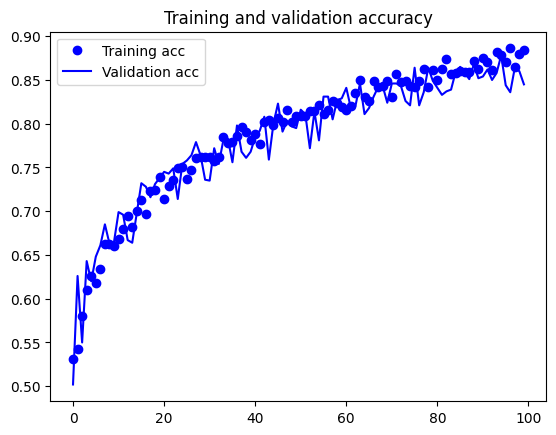

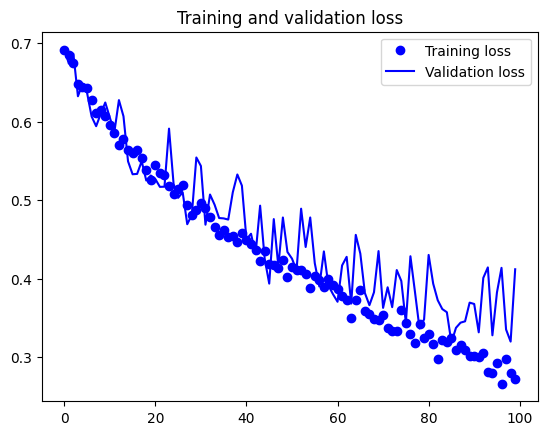

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()